In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/content/drive/MyDrive/DATA/RSCCASN.csv",index_col='DATE',parse_dates=True)

In [4]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [5]:
df.columns = ['Sales']

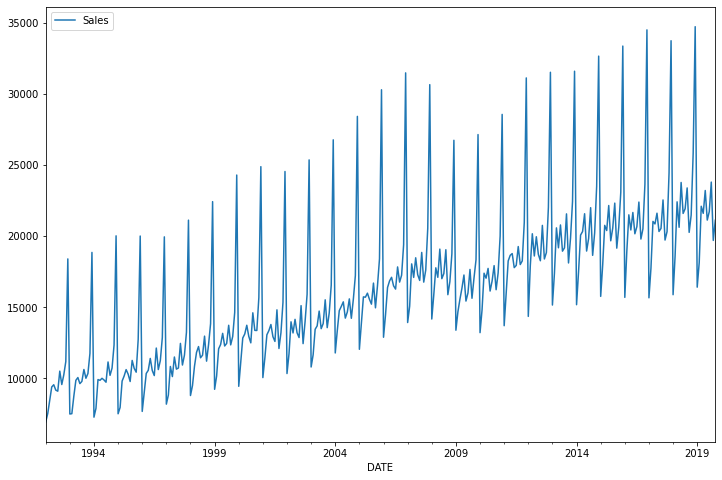

In [6]:
df.plot(figsize=(12,8))

Train Test Split

In [8]:
test_size  = 18
test_ind = len(df) - test_size
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]


Scale Data

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

Time Series Generator

In [10]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length = 12
generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)


How does the first batch look like

In [11]:
X,y = generator[0]
print(f'Given the Array: {X.flatten()}')
print(f'Predict this: {y}')

Given the Array: [0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this: [[0.02047633]]


Create the model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


In [13]:
n_features = 1

In [14]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


Early Stop and validation generator

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

Fit model to the generator

In [17]:
model.fit_generator(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


304/304 [==============================] - 6s 10ms/step - loss: 0.0248 - val_loss: 0.0079
Epoch 2/20
304/304 [==============================] - 3s 10ms/step - loss: 0.0190 - val_loss: 0.0219
Epoch 3/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0158 - val_loss: 0.0018
Epoch 4/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0118 - val_loss: 0.0077
Epoch 5/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0055 - val_loss: 0.0040


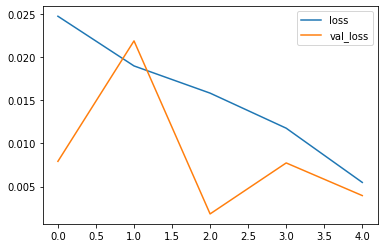

In [18]:
losses = pd.DataFrame(model.history.history)
losses.plot()

Evaluate on test Data

In [20]:
first_eval_batch = scaled_train[-length:]
first_eval_batch = first_eval_batch.reshape((1,length,n_features))
model.predict(first_eval_batch)
scaled_test[0]
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [21]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Sales,Predictions
DATE,,
2018-05-01,23764,22341.515664
2018-06-01,21589,21463.683252
2018-07-01,21919,21792.880462
2018-08-01,23381,23617.871478
2018-09-01,20260,21315.996317
2018-10-01,21473,22006.463972
2018-11-01,25831,26460.665615
2018-12-01,34706,38059.199956
2019-01-01,16410,17506.061013


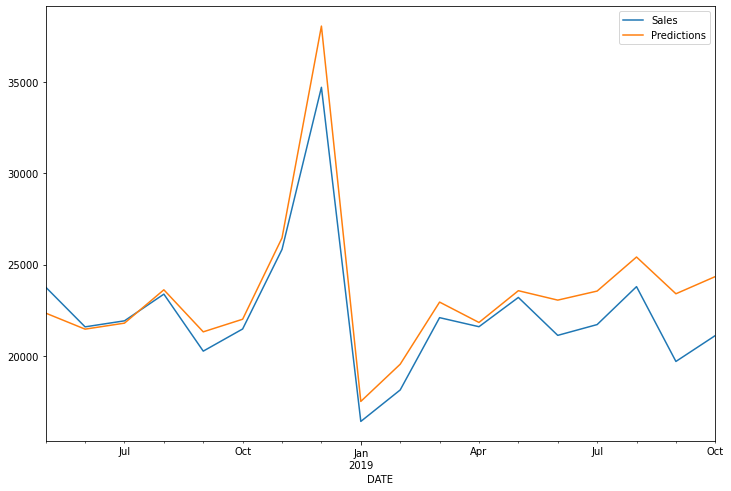

In [22]:
test.plot(figsize=(12,8))

Retrain and Forecasting

In [23]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [24]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [25]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


322/322 [==============================] - 5s 6ms/step - loss: 0.0253
Epoch 2/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0158
Epoch 3/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0112
Epoch 4/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0042
Epoch 5/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0031
Epoch 6/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0015
Epoch 7/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0013
Epoch 8/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0012


In [26]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [27]:
forecast = scaler.inverse_transform(forecast)

Creating new timestamp index with Pandas

In [28]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [29]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

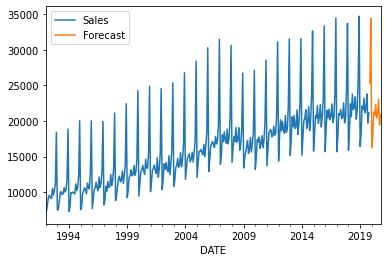

In [30]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

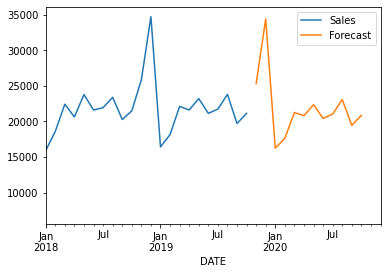

In [31]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')